# **Preprocesamiento y modelado de datos de viviendas**

## **Importación de librerías y carga de datos**

In [1]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
import optuna
import pickle
import bz2

## **Carga del dataset original (2011–2024)**

In [2]:
df_inicial = pd.read_csv("../data/final/viviendas_2011_2024.csv")
df_inicial.columns

Index(['Ano', 'Distrito', 'Esperanza_vida', 'Renta_neta_persona',
       'Renta_neta_hogar', 'Renta_bruta_persona', 'Renta_bruta_hogar',
       'Edad_media', 'Mayores_65anos%', 'Menores_18anos%',
       'Tamano_vivienda_personas', 'Paro_registrado%',
       'Apartamentos_turisticos', 'Superficie_distrito_ha',
       'Densidad_poblacion', 'Zonas_verdes%', 'Habitaciones', 'Operacion',
       'Tamano', 'Garaje', 'Trastero', 'Piscina', 'Terraza', 'Planta',
       'Exterior', 'Ascensor', 'Ano_construccion', 'Ano_reforma',
       'Tipo_vivienda', 'Banos', 'Precio_predicho', 'Precio_ajustado'],
      dtype='object')

## **Preprocesamiento**

En esta sección se realiza una **limpieza inicial del dataset** para conservar únicamente las variables útiles y mejorar la calidad de los datos:

- **Filtrado temporal:** se conservan solo los registros desde el año **2015**.
- **Eliminación de columnas con exceso de nulos:** se eliminan `Ano_construccion` y `Ano_reforma`.
- **Creación de un indicador de nulos:** se añade `Planta_is_missing` para identificar los casos con valores faltantes en `Planta`.
- **Imputación de valores faltantes:** se imputan los valores nulos de `Planta` con la **mediana por distrito**.
- **Eliminación de variables altamente correlacionadas:** se retiran variables redundantes que no serán utilizadas en el modelado.
- **Verificación final:** se muestran las columnas restantes tras la limpieza.


NOTA: Revisar notebook [EDA_viviendas_2011_2024](./EDA_viviendas_2011_2024.ipynb) para visualizar el análisis que da lugar a las decisiones tomadas en el preprocesamiento.

In [3]:
df = df_inicial.copy()

df = df[df['Ano'] >= 2015]

# Elminación de Ano_construccion y Ano_reforma por exceso de nulos
df = df.drop(columns=['Ano_construccion', 'Ano_reforma'])

# Crear columna de indicador de nulos para Planta
df['Planta_is_missing'] = df['Planta'].isna().astype(int)

# Imputar valores nulos con la mediana para Planta (por distrito)
df['Planta'] = df.groupby('Distrito')['Planta'].transform(lambda x: x.fillna(x.median()))

# Variables muy correlacionadas y no usadas
var_corr = ['Tamano_vivienda_personas', 'Densidad_poblacion', 'Edad_media', 'Renta_neta_persona',
            'Renta_neta_hogar', 'Renta_bruta_persona', 'Renta_bruta_hogar', 'Precio_predicho']

df = df.drop(columns=var_corr)

print('Columnas restantes:', df.columns.to_list())

Columnas restantes: ['Ano', 'Distrito', 'Esperanza_vida', 'Mayores_65anos%', 'Menores_18anos%', 'Paro_registrado%', 'Apartamentos_turisticos', 'Superficie_distrito_ha', 'Zonas_verdes%', 'Habitaciones', 'Operacion', 'Tamano', 'Garaje', 'Trastero', 'Piscina', 'Terraza', 'Planta', 'Exterior', 'Ascensor', 'Tipo_vivienda', 'Banos', 'Precio_ajustado', 'Planta_is_missing']


En esta etapa se calcula la **tendencia temporal (pendiente lineal)** de diversas variables socioeconómicas y demográficas a lo largo de los años, para cada distrito.

**Proceso:**
- Se define la función `calcular_tendencia`, que ajusta un **modelo de regresión lineal simple** (`LinearRegression`) entre el año (`Ano`) y cada variable de interés.
- Para cada variable:
  - Si los valores son **constantes** a lo largo del tiempo, la tendencia se define como `0.0`.
  - Si existen suficientes datos y variabilidad en `Ano`, se calcula la **pendiente** del modelo (`coef_[0]`), que representa la tasa de cambio anual.
  - Si no hay suficientes datos, se asigna `NaN`.

**Variables consideradas:**
- `Esperanza_vida`  
- `Mayores_65anos%`  
- `Menores_18anos%`  
- `Paro_registrado%`  
- `Apartamentos_turisticos`  
- `Superficie_distrito_ha`  
- `Zonas_verdes%`

El resultado final es un **DataFrame de tendencias por distrito**, donde cada columna indica la **variación anual promedio** de la variable correspondiente.

In [4]:
from sklearn.linear_model import LinearRegression

def calcular_tendencia(grupo, cols):
    X = grupo['Ano'].values.reshape(-1, 1)
    tendencias = {}
    for c in cols:
        y = grupo[c].values
        if np.allclose(y, y[0], atol=1e-8):  # valores constantes
            tendencias[c] = 0.0
        elif len(np.unique(X)) > 1:
            modelo = LinearRegression().fit(X, y)
            tendencias[c] = modelo.coef_[0]
        else:
            tendencias[c] = np.nan
    return pd.Series(tendencias)

variables = ['Esperanza_vida', 'Mayores_65anos%',
       'Menores_18anos%', 'Paro_registrado%', 'Apartamentos_turisticos',
       'Superficie_distrito_ha', 'Zonas_verdes%']
cols = ['Ano'] + variables
tendencias = df.dropna().groupby('Distrito')[cols].apply(calcular_tendencia, cols=variables).reset_index()

In [5]:
tendencias

,Distrito,Esperanza_vida,Mayores_65anos%,Menores_18anos%,Paro_registrado%,Apartamentos_turisticos,Superficie_distrito_ha,Zonas_verdes%
0,ARGANZUELA,-0.015476,0.003429,-0.002690,-0.002182,0.142857,0.0,0.0
1,BARAJAS,0.119048,0.002905,-0.002274,-0.001530,0.083333,0.0,0.0
2,CARABANCHEL,0.027381,-0.002262,-0.001845,-0.002469,0.547619,0.0,0.0
3,CENTRO,0.067857,-0.000940,-0.002607,-0.002150,3.404762,0.0,0.0
4,CHAMARTIN,0.032143,0.001143,-0.000310,-0.001232,0.190476,0.0,0.0
5,CHAMBERI,0.075000,0.000405,-0.001024,-0.001527,0.321429,0.0,0.0
6,CIUDADLINEAL,0.009524,-0.000619,-0.002143,-0.002183,0.285714,0.0,0.0
7,FUENCARRALELPARDO,0.041667,0.001774,0.000071,-0.001628,0.000000,0.0,0.0
8,HORTALEZA,0.091667,0.000214,0.000071,-0.001832,0.083333,0.0,0.0
9,LATINA,-0.019048,-0.002083,-0.001250,-0.002176,0.000000,0.0,0.0


Guardado de tendencias

In [6]:
tendencias.to_csv("../data/final/tendencias.csv")

## **Imputación de valores faltantes mediante tendencias por distrito**

En esta sección se utilizan las **tendencias lineales calculadas previamente** para imputar los valores faltantes de ciertas variables socioeconómicas a nivel de distrito.

**Resultado:**  
Un dataset sin valores nulos en las variables seleccionadas, imputadas de forma coherente con la evolución temporal observada en cada distrito.


In [7]:
# Renombrar columnas de tendencias para evitar confusión
tendencias_rename = {var: f'{var}_tendencia' for var in variables}
tendencias = tendencias.rename(columns=tendencias_rename)

# Aplicar por distrito (agregado include_groups=False)
vars_faltantes = ['Mayores_65anos%', 'Menores_18anos%', 'Paro_registrado%']

# Seleccionar solo columna Distrito y las tendencias que necesitamos
tendencias_merge = tendencias[['Distrito'] + [f'{var}_tendencia' for var in vars_faltantes]]

# Merge limpio
df = df.merge(tendencias_merge, on='Distrito', how='left')

# Crear indicadores de nulos
for var in vars_faltantes:
    df[f"{var}_is_missing"] = df[var].isna().astype(int)

# Función de imputación con tendencia
def imputar_con_tendencia(grupo, var):

    # Pendiente anual (tasa de cambio por año) a usar para extrapolación futura.
    tendencia = grupo[f'{var}_tendencia'].iloc[0]
    ultimo_valido = grupo[var].last_valid_index()
    
    # Si existe al menos un dato observado, extrapola SOLO para años posteriores.
    if ultimo_valido is not None:
        
        # Último valor y su año de referencia (punto base para la extrapolación lineal).
        ultimo_valor = grupo.loc[ultimo_valido, var]
        ultimo_ano = grupo.loc[ultimo_valido, 'Ano']
        
        # Imputa valores nulos en años futuros (> último_ano) extrapolando linealmente desde el último valor conocido usando la tendencia.
        mask_futuro = grupo[var].isna() & (grupo['Ano'] > ultimo_ano)
        grupo.loc[mask_futuro, var] = (ultimo_valor + tendencia * (grupo.loc[mask_futuro, 'Ano'] - ultimo_ano))
    
    # Relleno final de nulos restantes: ffill/bfill para nulos restantes
    return grupo[var].ffill().bfill()

for var in vars_faltantes:
    df[var] = df.groupby('Distrito', group_keys=False).apply(lambda g: imputar_con_tendencia(g, var), include_groups=False)

En esta última etapa se realiza una **limpieza posterior a la imputación** y una verificación general del estado del dataset.

**Eliminación de columnas auxiliares de tendencia:**  
   Las columnas utilizadas para la imputación (`*_tendencia`) ya no son necesarias,  
   por lo que se eliminan del DataFrame.

In [8]:
# Eliminar columnas de tendencias que ya no son necesarias tras la imputación
cols_tendencia = [col for col in df.columns if '_tendencia' in col]
df = df.drop(columns=cols_tendencia)

# Verificar estado final del dataset: tipos de datos y ausencia de nulos
resumen = pd.DataFrame({"Tipo": df.dtypes, "Nulos": df.isna().sum(), "Nulos_%": (df.isna().mean()*100).round(2)})
print(resumen)

                                Tipo  Nulos  Nulos_%
Ano                            int64      0      0.0
Distrito                      object      0      0.0
Esperanza_vida               float64      0      0.0
Mayores_65anos%              float64      0      0.0
Menores_18anos%              float64      0      0.0
Paro_registrado%             float64      0      0.0
Apartamentos_turisticos      float64      0      0.0
Superficie_distrito_ha       float64      0      0.0
Zonas_verdes%                float64      0      0.0
Habitaciones                   int64      0      0.0
Operacion                     object      0      0.0
Tamano                       float64      0      0.0
Garaje                          bool      0      0.0
Trastero                        bool      0      0.0
Piscina                         bool      0      0.0
Terraza                         bool      0      0.0
Planta                       float64      0      0.0
Exterior                        bool      0   

## **Creación de variables temporales y de contexto de mercado**

En esta sección se generan **nuevas características (features)** que capturan la **dinámica temporal y espacial del mercado inmobiliario**, con el fin de enriquecer el modelo predictivo.

**Resultado:**  
Se añaden múltiples **features temporales y de contexto local** que capturan la evolución de los precios, la estabilidad del mercado y la posición relativa de cada vivienda dentro de su entorno.

In [9]:
# Ordenar el dataframe por las columnas clave para calcular correctamente los lags temporales
df = df.sort_values(['Distrito', 'Tipo_vivienda', 'Ano']).reset_index(drop=True)

# --- FEATURE 1: Precio promedio año anterior por Distrito + Tipo_vivienda ---
# Compara cada vivienda con el precio medio de viviendas similares del año anterior
df['precio_prom_ano_ant'] = (df.groupby(['Distrito', 'Tipo_vivienda'])['Precio_ajustado'].shift(1))

# --- FEATURE 2: Tendencia de precio por Distrito (cambio porcentual) ---
# Captura la dinámica del mercado en cada distrito
df['tendencia_distrito'] = (
    df.groupby('Distrito')['Precio_ajustado']
    .pct_change()  # Variación porcentual respecto al periodo anterior
)

# --- FEATURE 3: Precio por m² del año anterior por Distrito ---
# Normaliza por tamaño para comparar valor relativo
df['precio_m2'] = df['Precio_ajustado'] / df['Tamano']
df['precio_m2_distrito_ant'] = (
    df.groupby('Distrito')['precio_m2']
    .shift(1)
)

# Eliminar columna auxiliar
df = df.drop(columns=['precio_m2'])

# --- FEATURE 4 (OPCIONAL): Ratio precio vs promedio del distrito ---
# Indica si la vivienda está por encima/debajo del mercado local
df['precio_prom_distrito'] = df.groupby(['Distrito', 'Ano'])['Precio_ajustado'].transform('mean')
df['ratio_vs_distrito'] = df['Precio_ajustado'] / df['precio_prom_distrito']
df = df.drop(columns=['precio_prom_distrito'])

# --- FEATURE 5 (OPCIONAL): Volatilidad del distrito ---
# Mide la variabilidad de precios en cada zona
df['volatilidad_distrito'] = (
    df.groupby(['Distrito', 'Ano'])['Precio_ajustado']
    .transform('std')  # Desviación estándar como proxy de volatilidad
)

# Imputar nulos resultantes de los lags (primer año de cada grupo)
# Usamos mediana por distrito para mantener coherencia espacial
for col in ['precio_prom_ano_ant', 'tendencia_distrito', 'precio_m2_distrito_ant', 'volatilidad_distrito']:
    if col in df.columns:
        df[col] = df.groupby('Distrito')[col].transform(lambda x: x.fillna(x.median()))

print("Features temporales agregadas creadas correctamente")
print(f"Nuevas columnas: {[c for c in df.columns if 'prom_ano' in c or 'tendencia' in c or 'm2_distrito' in c or 'ratio_vs' in c or 'volatilidad' in c]}")

Features temporales agregadas creadas correctamente
Nuevas columnas: ['precio_prom_ano_ant', 'tendencia_distrito', 'precio_m2_distrito_ant', 'ratio_vs_distrito', 'volatilidad_distrito']


## **Preparación del dataset y configuración del entrenamiento**

En esta sección se preparan los datos y la configuración necesaria para entrenar y evaluar distintos modelos predictivos.  
El objetivo es construir un flujo de trabajo **reproducible, limpio y compatible con validación temporal.**

**Resultado:**  
Dataset y entorno de entrenamiento completamente configurados, con los modelos listos para iniciar la fase de validación y comparación de desempeño.

In [10]:
# --- 1. Encoding de variables categóricas ---
df = pd.get_dummies(df, drop_first=True)
print(f"Shape después de get_dummies: {df.shape}")

# --- 2. Preparar dataset ---
df = df.sort_values(by="Ano").reset_index(drop=True)
df = df.dropna(subset=["Precio_ajustado"])
print(f"Dataset ordenado y limpio: {df.shape}")

# --- 3. Definir X / y ---
TARGET_COL = "Precio_ajustado"
DROP_COLS = ["Ano", TARGET_COL]

FEATURES = [c for c in df.columns if c not in DROP_COLS]
print(f"Total de features: {len(FEATURES)}")

# --- 4. Separación temporal ---
mask_train = (df["Ano"] <= 2022)
mask_test = (df["Ano"] >= 2023)

X_train = df.loc[mask_train, FEATURES]
y_train = df.loc[mask_train, TARGET_COL]
X_test = df.loc[mask_test, FEATURES]
y_test = df.loc[mask_test, TARGET_COL]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# --- 5. Definir pipeline (UNA SOLA VEZ) ---
def definir_pipeline(modelo) -> Pipeline:
    """
    Aplica escalado RobustScaler + modelo.
    
    Parameters
    ----------
    modelo : estimator
        Modelo de sklearn (Ridge, RandomForest, etc.)
    
    Returns
    -------
    pipeline : Pipeline
        Pipeline con scaler + modelo
    """
    pipeline = Pipeline([
        ('scaler', RobustScaler()), 
        ('modelo', modelo)
    ])
    return pipeline

# --- 6. Función de evaluación ---
def evaluar(model, X_tr, y_tr, X_va, y_va):
    """
    Entrena y evalúa un modelo con métricas completas.
    """
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    def mape(y_true, y_pred):
        eps = 1e-9
        return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": np.sqrt(mean_squared_error(y_va, pred_va)),
        "MAPE_val_%": mape(y_va, pred_va),
        "R2_val": r2_score(y_va, pred_va),
    }

# --- 7. Definir modelos ---
modelos = {
    "ridge": definir_pipeline(Ridge(alpha=1.0, random_state=42)),
    "knn":   definir_pipeline(KNeighborsRegressor(n_neighbors=7, weights="distance", n_jobs=-1)),
    "rf":    definir_pipeline(RandomForestRegressor(
                n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)),
    "hgb":   definir_pipeline(HistGradientBoostingRegressor(
                max_depth=None, learning_rate=0.06, max_iter=500, random_state=42)),
    "mlp":   definir_pipeline(MLPRegressor(
                hidden_layer_sizes=(64, 32),
                max_iter=300,
                activation="relu",
                learning_rate_init=1e-3,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=42)),
}

# --- 8. Validación temporal con TimeSeriesSplit ---
splits = 5
tscv = TimeSeriesSplit(n_splits=splits)
resultados = {}
entrenados = {}

print("Setup completado. Listo para entrenar modelos.")
print(df.columns)

Shape después de get_dummies: (149440, 56)
Dataset ordenado y limpio: (149440, 56)
Total de features: 54
Train: (119552, 54), Test: (29888, 54)
Setup completado. Listo para entrenar modelos.
Index(['Ano', 'Esperanza_vida', 'Mayores_65anos%', 'Menores_18anos%',
       'Paro_registrado%', 'Apartamentos_turisticos', 'Superficie_distrito_ha',
       'Zonas_verdes%', 'Habitaciones', 'Tamano', 'Garaje', 'Trastero',
       'Piscina', 'Terraza', 'Planta', 'Exterior', 'Ascensor', 'Banos',
       'Precio_ajustado', 'Planta_is_missing', 'Mayores_65anos%_is_missing',
       'Menores_18anos%_is_missing', 'Paro_registrado%_is_missing',
       'precio_prom_ano_ant', 'tendencia_distrito', 'precio_m2_distrito_ant',
       'ratio_vs_distrito', 'volatilidad_distrito', 'Distrito_BARAJAS',
       'Distrito_CARABANCHEL', 'Distrito_CENTRO', 'Distrito_CHAMARTIN',
       'Distrito_CHAMBERI', 'Distrito_CIUDADLINEAL',
       'Distrito_FUENCARRALELPARDO', 'Distrito_HORTALEZA', 'Distrito_LATINA',
       'Distrito_

## **Entrenamiento y validación temporal de modelos**

En esta sección se realiza el **entrenamiento con validación temporal** utilizando el método `TimeSeriesSplit`, asegurando que la evaluación de los modelos respete la secuencia cronológica de los datos.

**Resultado:**  
Se obtienen modelos validados temporalmente, con métricas de desempeño en distintos periodos,  
y versiones finales entrenadas con todos los datos históricos disponibles.

**Entrenamientos de prueba (descomentar para ejecutar):**

In [ ]:
print("Iniciando entrenamiento con TimeSeriesSplit...\n")

# Entrenamientos de prueba
for nombre, pipe in modelos.items():
    print(f"Entrenando modelo: {nombre.upper()}")
    resultados_modelo = []
    n_validacion = 0
    
    for train_index, val_index in tscv.split(X_train):
        n_validacion += 1
        print(f"   Split {n_validacion}/{splits}")

        pipe_cv = clone(pipe)

        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        metrics = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
        resultados_modelo.append(metrics)

    resultados[nombre] = resultados_modelo

    # Entrenamiento final con todo el train set
    print(f"   Fit final en {X_train.shape[0]} muestras\n")
    pipe_final = clone(pipe).fit(X_train, y_train)
    entrenados[nombre] = pipe_final

Iniciando entrenamiento con TimeSeriesSplit...

Entrenando modelo: RIDGE
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 119552 muestras

Entrenando modelo: KNN
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 119552 muestras

Entrenando modelo: RF
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 119552 muestras

Entrenando modelo: HGB
   Split 1/5
   Split 2/5
   Split 3/5
   Split 4/5
   Split 5/5
   Fit final en 119552 muestras

Entrenando modelo: MLP
   Split 1/5


C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


   Split 2/5
   Split 3/5
   Split 4/5


C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


   Split 5/5
   Fit final en 119552 muestras



**Mostrar resultados de validación cruzada**

En esta sección se presentan los **resultados de la validación temporal (2015–2022)** para todos los modelos entrenados.  
El objetivo es comparar su desempeño y seleccionar el modelo más prometedor según las métricas de evaluación.

Un resumen claro del rendimiento de cada modelo, destacando el mejor candidato para predicciones futuras.

In [ ]:
print("\n" + "="*70)
print("RESULTADOS DE VALIDACIÓN CRUZADA (2015-2022)")
print("="*70)

ranking = sorted(
    resultados.items(),
    key=lambda kv: min([m["MAE_val"] for m in kv[1]])
)

for nombre, metricas in ranking:
    mae_vals = [m["MAE_val"] for m in metricas]
    rmse_vals = [m["RMSE_val"] for m in metricas]
    r2_vals = [m["R2_val"] for m in metricas]
    mape_vals = [m["MAPE_val_%"] for m in metricas]

    mae_tr_vals = [m["MAE_train"] for m in metricas]
    rmse_tr_vals = [m["RMSE_train"] for m in metricas]
    r2_tr_vals = [m["R2_train"] for m in metricas]

    print(f"\n{nombre.upper()}:")
    print(f"  Validación:")
    print(f"    MAE    = {min(mae_vals):,.2f} EUR")
    print(f"    RMSE   = {min(rmse_vals):,.2f} EUR")
    print(f"    R2     = {max(r2_vals):.4f}")
    print(f"    MAPE   = {min(mape_vals):.2f}%")
    print(f"  Entrenamiento:")
    print(f"    MAE    = {min(mae_tr_vals):,.2f} EUR")
    print(f"    RMSE   = {min(rmse_tr_vals):,.2f} EUR")
    print(f"    R2     = {max(r2_tr_vals):.4f}")

mejor_nombre = ranking[0][0]
mejor_modelo = entrenados[mejor_nombre]

print("\n" + "="*70)
print(f"MEJOR MODELO: {mejor_nombre.upper()}")
print("="*70)


RESULTADOS DE VALIDACIÓN CRUZADA (2015-2022)

RF:
  Validación:
    MAE    = 12,753.53 EUR
    RMSE   = 31,174.04 EUR
    R2     = 0.9952
    MAPE   = 5.12%
  Entrenamiento:
    MAE    = 708.07 EUR
    RMSE   = 5,136.91 EUR
    R2     = 0.9999

HGB:
  Validación:
    MAE    = 13,391.27 EUR
    RMSE   = 41,374.94 EUR
    R2     = 0.9918
    MAPE   = 27.76%
  Entrenamiento:
    MAE    = 3,419.50 EUR
    RMSE   = 14,785.77 EUR
    R2     = 0.9987

MLP:
  Validación:
    MAE    = 17,441.96 EUR
    RMSE   = 36,927.31 EUR
    R2     = 0.9955
    MAPE   = 65.15%
  Entrenamiento:
    MAE    = 7,338.20 EUR
    RMSE   = 23,258.55 EUR
    R2     = 0.9973

KNN:
  Validación:
    MAE    = 28,319.48 EUR
    RMSE   = 75,495.15 EUR
    R2     = 0.9772
    MAPE   = 16.51%
  Entrenamiento:
    MAE    = 0.01 EUR
    RMSE   = 0.06 EUR
    R2     = 1.0000

RIDGE:
  Validación:
    MAE    = 66,879.49 EUR
    RMSE   = 106,132.32 EUR
    R2     = 0.9133
    MAPE   = 2535.00%
  Entrenamiento:
    MAE    = 66,

## **Optimización de hiperparámetros con Optuna (Random Forest)**

En esta sección se realiza la **optimización automática de hiperparámetros** del modelo **Random Forest** utilizando la librería **Optuna**, con el objetivo de minimizar el error medio absoluto (MAE) en validación temporal.

**Resultado:**  
Un modelo **Random Forest optimizado** mediante búsqueda automática de hiperparámetros,  
validado temporalmente y listo para compararse con los demás modelos base.

In [ ]:
print("\nIniciando optimización de hiperparámetros con Optuna...")
print(f"Usando TimeSeriesSplit con {splits} splits\n")

def objective_rf(trial):
    """
    Función objetivo para Optuna: minimiza MAE promedio en validación cruzada.
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 400, step=50),
        "max_depth": trial.suggest_int("max_depth", 10, 30, step=5),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.8]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_jobs": -1,
        "random_state": 42
    }

    pipe = definir_pipeline(RandomForestRegressor(**params))

    maes = []
    for train_idx, val_idx in tscv.split(X_train):
        pipe_cv = clone(pipe)

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        mets = evaluar(pipe_cv, X_tr, y_tr, X_val, y_val)
        maes.append(mets["MAE_val"])

    return np.mean(maes)

# Crear estudio de Optuna
study = optuna.create_study(direction="minimize", study_name="Optimizacion_RF")
study.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print("\n" + "="*70)
print("RESULTADOS DE OPTIMIZACIÓN")
print("="*70)
print(f"Mejor MAE validación: {study.best_value:,.2f} EUR")
print(f"\nMejores hiperparámetros:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

# Entrenar modelo final con los mejores parámetros
print("\nEntrenando modelo final con mejores hiperparámetros...")
mejor_rf = definir_pipeline(RandomForestRegressor(**study.best_params))
mejor_rf.fit(X_train, y_train)

# Guardar en el diccionario de modelos entrenados
entrenados["rf_optimizado"] = mejor_rf
print("Modelo optimizado guardado como 'rf_optimizado'")

[I 2025-10-10 14:05:09,146] A new study created in memory with name: Optimizacion_RF



Iniciando optimización de hiperparámetros con Optuna...
Usando TimeSeriesSplit con 5 splits



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-10 14:05:26,842] Trial 0 finished with value: 52516.36841685525 and parameters: {'n_estimators': 350, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 52516.36841685525.
[I 2025-10-10 14:07:45,749] Trial 1 finished with value: 18384.76612927138 and parameters: {'n_estimators': 400, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8, 'bootstrap': True}. Best is trial 1 with value: 18384.76612927138.
[I 2025-10-10 14:08:20,639] Trial 2 finished with value: 23519.13105642005 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 18384.76612927138.
[I 2025-10-10 14:10:41,648] Trial 3 finished with value: 18552.1717154296 and parameters: {'n_estimators': 350, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.8

**Entrenamiento del modelo Random Forest final con los mejores hiperparámetros (descomentar para ejecutar)**

Se entrena el modelo Random Forest utilizando los hiperparámetros óptimos encontrados con Optuna. El modelo final se integra en un pipeline con escalado robusto y se ajusta sobre los datos de entrenamiento completos, obteniendo así la versión definitiva lista para evaluación y predicciones futuras.

In [13]:
# # ===== Entrenar el mejor modelo RF final =====
rf_final = definir_pipeline(RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=42))

# # Entrenar con todos los datos (ya que es una serie temporal)
# rf_final.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('modelo',
                 RandomForestRegressor(max_depth=20, max_features=0.8,
                                       min_samples_split=4, n_estimators=400,
                                       n_jobs=-1, random_state=42))])

Guardar modelo

In [14]:
with bz2.open('rf_final.pkl.bz2', 'wb') as f:
    pickle.dump(rf_final, f)

Cargar modelo

In [26]:
with bz2.open('rf_final.pkl.bz2', 'rb') as f:
    rf_final = pickle.load(f)

c:\Users\campu\Desktop\notebook\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\campu\Desktop\notebook\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\campu\Desktop\notebook\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 wh

**Análisis de la importancia de variables en el modelo Random Forest**

Se extraen y visualizan las variables con mayor peso en el modelo final de Random Forest. Este análisis permite identificar los factores que más influyen en la predicción del precio ajustado, mostrando las 15 variables más relevantes mediante una tabla y un gráfico de barras.

,Variable,Importancia
24,ratio_vs_distrito,0.616611
21,precio_prom_ano_ant,0.175850
25,volatilidad_distrito,0.097827
8,Tamano,0.042786
23,precio_m2_distrito_ant,0.019956
22,tendencia_distrito,0.016119
3,Paro_registrado%,0.007928
46,Operacion_venta,0.007915
6,Zonas_verdes%,0.004582
4,Apartamentos_turisticos,0.004410


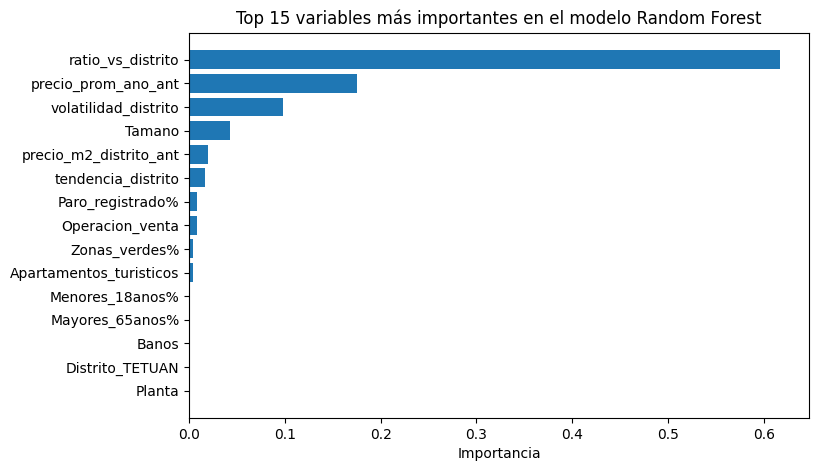

In [28]:
import matplotlib.pyplot as plt

# Extraer importancias
importancias = rf_final.named_steps['modelo'].feature_importances_
features = X_train.columns

# Crear DataFrame ordenado
imp_df = pd.DataFrame({
    'Variable': features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False).head(15)

# Mostrar tabla y gráfico
display(imp_df)

plt.figure(figsize=(8,5))
plt.barh(imp_df['Variable'], imp_df['Importancia'])
plt.gca().invert_yaxis()
plt.title('Top 15 variables más importantes en el modelo Random Forest')
plt.xlabel('Importancia')
plt.show()

Evaluación en 2023 y 2024

Nulos en X_test:
0

EVALUACIÓN FINAL EN TEST (2023-2024)
MAE:  25035.77
RMSE: 67255.99
R²:   0.9872
MAPE: 6.83%


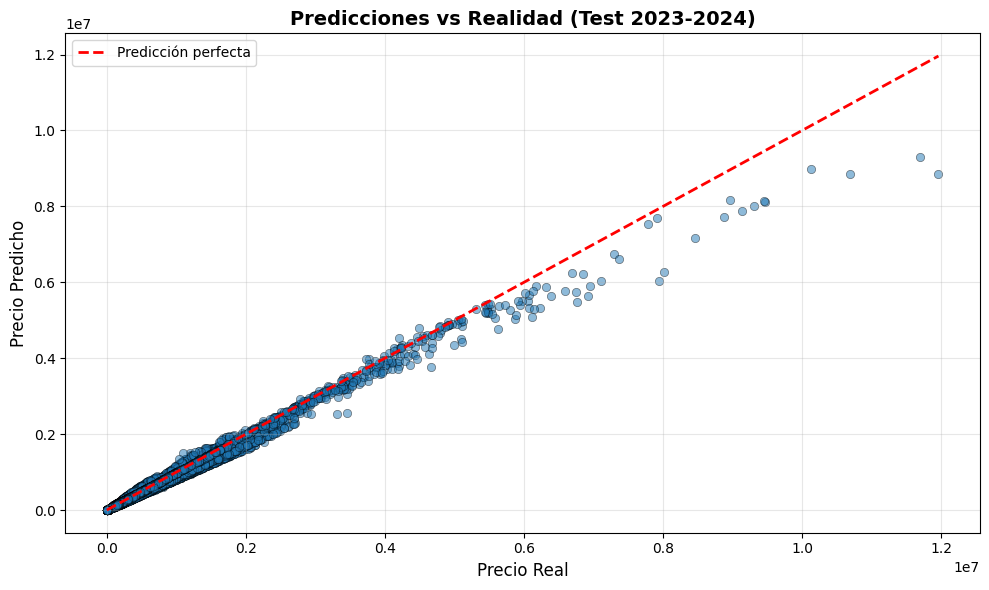

In [31]:
# Verificar que X_test no tenga nulos
print("Nulos en X_test:")
print(X_test.isna().sum().sum())

# Si no hay nulos, evaluar directamente
y_pred_test = rf_final.predict(X_test)

print("\n" + "="*50)
print("EVALUACIÓN FINAL EN TEST (2023-2024)")
print("="*50)

print(f"MAE:  {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"R²:   {r2_score(y_test, y_pred_test):.4f}")

# MAPE
mape_test = np.mean(np.abs((y_test - y_pred_test) / (np.abs(y_test) + 1e-9))) * 100
print(f"MAPE: {mape_test:.2f}%")

# Comparación visual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Precio Real', fontsize=12)
plt.ylabel('Precio Predicho', fontsize=12)
plt.title('Predicciones vs Realidad (Test 2023-2024)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
# Análisis de errores
errores = y_test - y_pred_test
errores_abs = np.abs(errores)
errores_rel = np.abs(errores / y_test) * 100

print("Análisis de errores:")
print(f"Error medio: {errores.mean():.2f} (sesgo)")
print(f"Mediana del error absoluto: {np.median(errores_abs):.2f}")
print(f"Percentil 90 del error relativo: {np.percentile(errores_rel, 90):.2f}%")
print(f"% predicciones con error <10%: {(errores_rel < 10).mean() * 100:.1f}%")
print(f"% predicciones con error >50%: {(errores_rel > 50).mean() * 100:.1f}%")

# Identificar peores predicciones
peores = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred_test,
    'Error_abs': errores_abs,
    'Error_rel_%': errores_rel
}).sort_values('Error_abs', ascending=False).head(10)

print("\nPeores 10 predicciones:")
display(peores)

Análisis de errores:
Error medio: 17673.63 (sesgo)
Mediana del error absoluto: 5906.35
Percentil 90 del error relativo: 15.17%
% predicciones con error <10%: 76.7%
% predicciones con error >50%: 0.0%

Peores 10 predicciones:


,Real,Predicho,Error_abs,Error_rel_%
135660,1.196070e+07,8.843429e+06,3.117275e+06,26.062637
135535,1.170186e+07,9.297294e+06,2.404566e+06,20.548577
143196,7.947467e+06,6.041878e+06,1.905589e+06,23.977318
133331,1.068587e+07,8.857346e+06,1.828527e+06,17.111629
143568,8.015293e+06,6.271095e+06,1.744197e+06,21.760867
127156,9.462459e+06,8.121958e+06,1.340501e+06,14.166515
135438,9.458413e+06,8.141127e+06,1.317286e+06,13.927140
138165,8.462596e+06,7.170291e+06,1.292304e+06,15.270779
138166,9.305896e+06,8.015667e+06,1.290229e+06,13.864641
146968,6.923591e+06,5.645630e+06,1.277960e+06,18.458056


Rendimiento por rango de precio:



C:\Users\campu\AppData\Local\Temp\ipykernel_17796\2335676720.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_rangos = df_errores.groupby('Rango').agg({


,MAE,Mediana_error,Error_rel_%_medio,Error_rel_%_mediano,n_casos
Rango,,,,,
<300k,6291.11,192.55,6.56,5.13,19832
300-600k,33105.12,26752.43,7.75,6.55,4855
600k-1M,52261.77,45581.07,6.76,6.35,2570
1-2M,101488.61,84543.67,7.51,6.73,2091
>2M,215283.33,125970.67,5.98,4.19,540


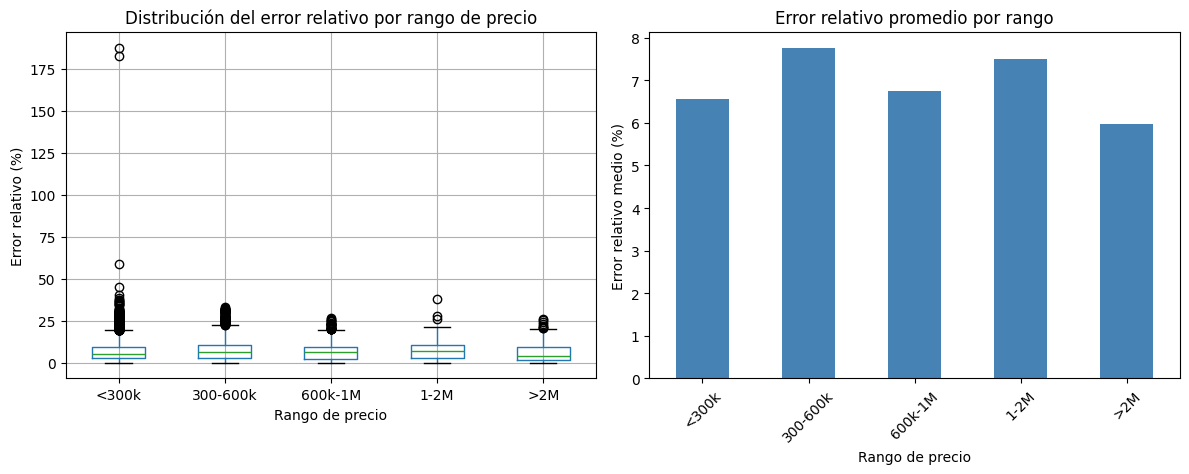

In [33]:
# Crear rangos de precio
bins = [0, 300000, 600000, 1000000, 2000000, np.inf]
labels = ['<300k', '300-600k', '600k-1M', '1-2M', '>2M']

df_errores = pd.DataFrame({
    'Real': y_test.values,
    'Predicho': y_pred_test,
    'Error_abs': errores_abs,
    'Error_rel_%': errores_rel
})

df_errores['Rango'] = pd.cut(df_errores['Real'], bins=bins, labels=labels)

# Análisis por rango
print("Rendimiento por rango de precio:\n")
resumen_rangos = df_errores.groupby('Rango').agg({
    'Error_abs': ['mean', 'median'],
    'Error_rel_%': ['mean', 'median'],
    'Real': 'count'
}).round(2)

resumen_rangos.columns = ['MAE', 'Mediana_error', 'Error_rel_%_medio', 'Error_rel_%_mediano', 'n_casos']
display(resumen_rangos)

# Visualizar errores por rango
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_errores.boxplot(column='Error_rel_%', by='Rango', ax=plt.gca())
plt.title('Distribución del error relativo por rango de precio')
plt.ylabel('Error relativo (%)')
plt.xlabel('Rango de precio')
plt.suptitle('')

plt.subplot(1, 2, 2)
resumen_rangos['Error_rel_%_medio'].plot(kind='bar', color='steelblue')
plt.title('Error relativo promedio por rango')
plt.ylabel('Error relativo medio (%)')
plt.xlabel('Rango de precio')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [35]:
# Identificar casos problemáticos en <300k
df_bajo = df_errores[df_errores['Rango'] == '<300k']
casos_extremos = df_bajo[df_bajo['Error_rel_%'] > 100]

print(f"Casos con error >100% en segmento <300k: {len(casos_extremos)} ({len(casos_extremos)/len(df_bajo)*100:.2f}%)")
print(f"\nEstadísticas de estos casos extremos:")
print(f"Precio real promedio: {casos_extremos['Real'].mean():.2f}")
print(f"Precio predicho promedio: {casos_extremos['Predicho'].mean():.2f}")

# Obtener índices para investigar features
indices_extremos = casos_extremos.index.tolist()[:5]
print(f"\nPrimeros 5 casos extremos (índices): {indices_extremos}")

Casos con error >100% en segmento <300k: 2 (0.01%)

Estadísticas de estos casos extremos:
Precio real promedio: 5179.77
Precio predicho promedio: 14747.48

Primeros 5 casos extremos (índices): [131934, 148062]


In [36]:
def evaluar_sin_fit(model, X_tr, y_tr, X_va, y_va):
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    def mape(y_true, y_pred):
        eps = 1e-9
        return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": np.sqrt(mean_squared_error(y_va, pred_va)),
        "MAPE_val_%": mape(y_va, pred_va),
        "R2_val": r2_score(y_va, pred_va),
    }

In [37]:
print("\n--- Evaluación en 2023 ---")
eval_2023 = evaluar_sin_fit(rf_final, X_train, y_train,
                    X_test.loc[df["Ano"] == 2023],
                    y_test.loc[df["Ano"] == 2023])
print(eval_2023)

print("\n--- Evaluación en 2024 ---")
eval_2024 = evaluar_sin_fit(rf_final, X_train, y_train,
                    X_test.loc[df["Ano"] == 2024],
                    y_test.loc[df["Ano"] == 2024])
print(eval_2024)


--- Evaluación en 2023 ---
{'MAE_train': 862.0983202586106, 'RMSE_train': np.float64(6352.790939541452), 'R2_train': 0.9998125130698174, 'MAE_val': 14148.668610761106, 'RMSE_val': np.float64(38100.872272365705), 'MAPE_val_%': np.float64(4.330735532615523), 'R2_val': 0.995311070936486}

--- Evaluación en 2024 ---
{'MAE_train': 862.0983202586108, 'RMSE_train': np.float64(6352.790939541453), 'R2_train': 0.9998125130698174, 'MAE_val': 35922.87425880198, 'RMSE_val': np.float64(87149.6485593217), 'MAPE_val_%': np.float64(9.324464533227918), 'R2_val': 0.9807936930242281}


**Comparativa de desempeño entre el modelo base y el modelo optimizado**

Se comparan los resultados del modelo Random Forest inicial frente al modelo optimizado tras la búsqueda de hiperparámetros. El modelo ajustado muestra una mejora en el MAE y MAPE de validación, manteniendo un R² alto, lo que confirma una mayor precisión y mejor capacidad de generalización.

In [24]:
rf_base = entrenados["rf"]  # el modelo base antes del tuning

base_mets = resultados["rf"]
tuned_mets = evaluar(rf_final, X_train, y_train, X_val, y_val)

print("\n--- Comparativa Random Forest ---")
print("Base :", base_mets)
print("Tuned:", tuned_mets)


--- Comparativa Random Forest ---
Base : [{'MAE_train': 1068.014829082451, 'RMSE_train': 14619.224654970427, 'R2_train': 0.9986027531683999, 'MAE_val': 13762.263627972388, 'RMSE_val': 47161.27899668593, 'MAPE_val_%': 7.917847234469987, 'R2_val': 0.9804848400853593}, {'MAE_train': 769.5430203325614, 'RMSE_train': 6731.479173306825, 'R2_train': 0.9996606792298528, 'MAE_val': 30908.382362988465, 'RMSE_val': 79160.33422958058, 'MAPE_val_%': 9.198850231846762, 'R2_val': 0.9745361798855395}, {'MAE_train': 795.7375855810279, 'RMSE_train': 8659.871351782369, 'R2_train': 0.9995647290710645, 'MAE_val': 21766.92815157518, 'RMSE_val': 52236.18839843903, 'MAPE_val_%': 7.277806860839718, 'R2_val': 0.9897063499058688}, {'MAE_train': 770.4046641066246, 'RMSE_train': 6757.752749157956, 'R2_train': 0.9997673992670149, 'MAE_val': 12753.526853434436, 'RMSE_val': 31174.035136831735, 'MAPE_val_%': 5.235402972244318, 'R2_val': 0.9952055716605265}, {'MAE_train': 708.0741830084431, 'RMSE_train': 5136.90578011

In [ ]:
# Asegurarnos de usar todo el test set
y_pred_test_final = rf_final.predict(X_test)

print("\n" + "="*60)
print("MÉTRICAS FINALES EN TEST COMPLETO (2023-2024)")
print("="*60)
print(f"MAE:  {mean_absolute_error(y_test, y_pred_test_final):,.2f} EUR")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_final)):,.2f} EUR")
print(f"R²:   {r2_score(y_test, y_pred_test_final):.4f}")

mape_final = np.mean(np.abs((y_test - y_pred_test_final) / (np.abs(y_test) + 1e-9))) * 100
print(f"MAPE: {mape_final:.2f}%")
print("="*60)


MÉTRICAS FINALES EN TEST COMPLETO (2023-2024)
MAE:  25,035.77 EUR
RMSE: 67,255.99 EUR
R²:   0.9872
MAPE: 6.83%
